In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('SAML-D.csv')

In [ ]:
df.columns

In [ ]:
df.shape

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
df.iloc[:,5].value_counts()

In [ ]:
df.iloc[:,6].value_counts()

In [ ]:
df.iloc[:,7].value_counts()

In [ ]:
df.iloc[:,8].value_counts()

In [ ]:
df.iloc[:,9].value_counts()

In [ ]:
df['Laundering_type'].unique()

In [ ]:
df['Is_laundering'].unique()

In [ ]:
df[df['Is_laundering']==1]['Laundering_type'].unique()

In [ ]:
df['Is_laundering'].value_counts()[1] / df['Is_laundering'].value_counts()[0] * 100

In [ ]:
98

In [ ]:
df.shape[0] * 0.103981 / 100

In [ ]:
df[df['Is_laundering']==1]

In [ ]:
df.shape

In [ ]:
df = df.drop_duplicates(keep = 'first')
df.shape

In [ ]:
df.isna().sum()

In [ ]:
df.info()

In [ ]:
df[df['Is_laundering']==1]['Laundering_type'].value_counts()

In [ ]:
df[df['Is_laundering']==0]['Laundering_type'].value_counts()

In [ ]:
# Convert time and date columns to datetime objects
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [ ]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [ ]:
df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['Second'] = df['Time'].dt.second

In [3]:
# Drop the original Date and Time columns
df = df.drop(columns=['Date', 'Time'])

In [4]:
df = df.drop(columns=['Sender_account', 'Receiver_account'])

In [ ]:
cat_cols = [
    'Payment_currency', 
    'Received_currency', 
    'Sender_bank_location', 
    'Receiver_bank_location', 
    'Payment_type'
]
# One-hot encode categorical variables
df = pd.get_dummies(df, columns=cat_cols)

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from catboost import CatBoostClassifier, Pool
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier

In [6]:
cat_cols = [
    'Payment_currency', 
    'Received_currency', 
    'Sender_bank_location', 
    'Receiver_bank_location', 
    'Payment_type'
]

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' to avoid multicollinearity

# Fit and transform the encoder on the specified columns
encoded_arrays = encoder.fit_transform(df[cat_cols]).astype('int32')

# Convert the encoded arrays to a DataFrame
encoded_df = pd.DataFrame(encoded_arrays, columns=encoder.get_feature_names_out(cat_cols))

# Concatenate the original dataframe (excluding the encoded columns) with the encoded dataframe
df = pd.concat([df.drop(columns=cat_cols), encoded_df], axis=1)

In [ ]:
# Encoding categorical variables
label_encoders = {}
categorical_columns = ['Sender_account', 'Receiver_account']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
#samples = df.sample(n=1000000, random_state=68).index

In [7]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the 'Amount' field
df['Amount'] = scaler.fit_transform(df[['Amount']])

In [ ]:
df.head()

In [8]:
# Define the proportion of the dataset we want to sample
subset_size = 0.1  # 10% of the dataset

# Perform stratified sampling
df_subset, _ = train_test_split(df, test_size=(1 - subset_size), stratify=df['Is_laundering'], random_state=68)

# Check the distribution in the subset
print(df_subset['Is_laundering'].value_counts(normalize=True))
print(df['Is_laundering'].value_counts(normalize=True))

Is_laundering
0    0.998962
1    0.001038
Name: proportion, dtype: float64
Is_laundering
0    0.998961
1    0.001039
Name: proportion, dtype: float64


In [9]:
samples = df_subset.index

In [ ]:
df.iloc[samples]['Is_laundering'].value_counts(normalize=True)

In [10]:
X = df.iloc[samples].drop(columns=['Is_laundering','Laundering_type']) 
y = df.iloc[samples]['Is_laundering'] # dependent variable

In [ ]:
y.value_counts(normalize=True)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=68, stratify=y)

In [ ]:
y_test.value_counts(normalize=True)

In [ ]:
X_resampled = X_train
y_resampled = y_train
# Feature scaling
#scaler = StandardScaler()
#X_resampled = scaler.fit_transform(X_resampled)
#X_test = scaler.transform(X_test)

In [ ]:

# SMOTE model to create synthetic samples for the minority class (Is_laundering == 1)
# samples of Is_laundering as 1 set at 50% of the samples of Is_landering as 0 
#smote = SMOTE(sampling_strategy=0.5, random_state=68)
#X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [12]:
# Handling class imbalance using SMOTE and undersampling
over = SMOTE(sampling_strategy=0.2, random_state=68)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

# Feature scaling
#scaler = StandardScaler()
#X_resampled = scaler.fit_transform(X_resampled)
#X_test = scaler.transform(X_test)

In [ ]:
X_resampled.shape

In [13]:
y_resampled.value_counts(normalize=True)

Is_laundering
0    0.666667
1    0.333333
Name: proportion, dtype: float64

In [14]:
def gboost(X_train, y_train, X_test, y_test, random_state=68):
    gb_model = GradientBoostingClassifier(random_state=random_state)
    gb_model.fit(X_train, y_train)
    predictions = gb_model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy: {accuracy}\n")
    print("Classification Report:")
    print(classification_report(y_test, predictions))
    
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    return gb_model

In [ ]:
def neuralnetwork(X_train, y_train, X_test, y_test, random_state=68):
    nn_model = MLPClassifier()
    nn_model.fit(X_train, y_train)
    predictions = nn_model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy: {accuracy}\n")
    print("Classification Report:")
    print(classification_report(y_test, predictions))
    
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    return nn_model

In [15]:
def randomforest(X_train, y_train, X_test, y_test, random_state=68):
    rf_model = RandomForestClassifier(random_state=random_state)
    rf_model.fit(X_train, y_train)
    predictions = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy: {accuracy}\n")
    print("Classification Report:")
    print(classification_report(y_test, predictions))
    
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    return rf_model

In [16]:
def xgboost(X_train, y_train, X_test, y_test, random_state=68):
    xgb_model = xgb.XGBClassifier()
    xgb_model.fit(X_train, y_train)

    #y_train_pred = xgb_model.predict(X_train)
    y_test_pred = xgb_model.predict(X_test)
    
    #accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    #print(f"Accuracy (Training Set): {accuracy_train:.4f}")
    print(f"Accuracy (Testing Set): {accuracy_test:.4f}")
    
    #cm_train = confusion_matrix(y_train, y_train_pred)
    #print("\nConfusion Matrix (Training Set):\n", cm_train)
    
    cm_test = confusion_matrix(y_test, y_test_pred)
    print("\nConfusion Matrix (Testing Set):\n", cm_test)
    print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred))
    
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    return xgb_model

In [17]:
def catboost(X_train, y_train, X_test, y_test, random_state=68):
    cat_model = CatBoostClassifier(iterations=1000,  # Number of trees (iterations)
                           learning_rate=0.1,  # Learning rate
                           depth=6,  # Depth of trees
                           random_state=random_state,  # Random state for reproducibility
                           verbose=0)
    cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50, verbose=100)

    #y_train_pred = cat_model.predict(X_train)
    y_test_pred = cat_model.predict(X_test)
    
    #accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    #print(f"Accuracy (Training Set): {accuracy_train:.4f}")
    print(f"Accuracy (Testing Set): {accuracy_test:.4f}")
    
    #cm_train = confusion_matrix(y_train, y_train_pred)
    #print("\nConfusion Matrix (Training Set):\n", cm_train)
    
    cm_test = confusion_matrix(y_test, y_test_pred)
    print("\nConfusion Matrix (Testing Set):\n", cm_test)

    print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred))
    
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    
    return cat_model



In [18]:
def cartmodel(X_train, y_train, X_test, y_test, random_state=68):
    dt_model = DecisionTreeClassifier(random_state=68)
    dt_model.fit(X_train, y_train)
    
    #y_train_pred = dt_model.predict(X_train)
    y_test_pred = dt_model.predict(X_test)
    
    #accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    #print(f"Accuracy (Training Set): {accuracy_train:.4f}")
    print(f"Accuracy (Testing Set): {accuracy_test:.4f}")
    
    #cm_train = confusion_matrix(y_train, y_train_pred)
    #print("\nConfusion Matrix (Training Set):\n", cm_train)
    
    cm_test = confusion_matrix(y_test, y_test_pred)
    print("\nConfusion Matrix (Testing Set):\n", cm_test)

    print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred))
    
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    
    return dt_model

In [19]:
def logitregression(X_train, y_train, X_test, y_test, random_state=68, max_iter=100):
    lg_model = LogisticRegression(max_iter=max_iter, random_state=random_state)
    lg_model.fit(X_train, y_train)
    
    #y_train_pred = lg_model.predict(X_train)
    y_test_pred = lg_model.predict(X_test)
    
    #accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    #print(f"Accuracy (Training Set): {accuracy_train:.4f}")
    print(f"Accuracy (Testing Set): {accuracy_test:.4f}")
    
    #cm_train = confusion_matrix(y_train, y_train_pred)
    #print("\nConfusion Matrix (Training Set):\n", cm_train)
    
    cm_test = confusion_matrix(y_test, y_test_pred)
    print("\nConfusion Matrix (Testing Set):\n", cm_test)

    print("\nClassification Report (Testing Set):\n", classification_report(y_test, y_test_pred))
    
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    
    return lg_model

Accuracy: 0.9038641203255591

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    237375
           1       0.01      0.50      0.01       247

    accuracy                           0.90    237622
   macro avg       0.50      0.70      0.48    237622
weighted avg       1.00      0.90      0.95    237622



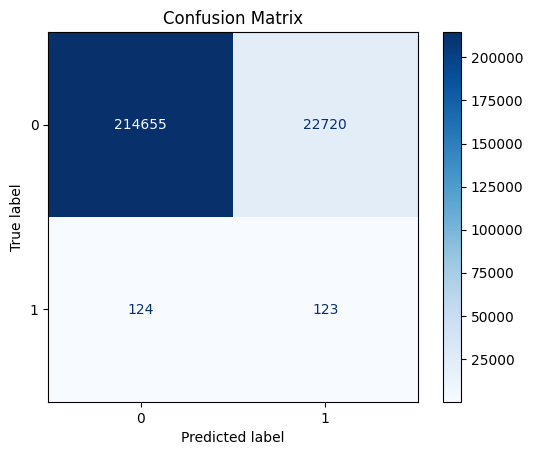

In [20]:
gboost_model = gboost(X_resampled, y_resampled, X_test, y_test, random_state=68)

In [ ]:
#nnetwork_model = neuralnetwork(X_train, y_train, X_test, y_test, random_state=68)

Accuracy: 0.8377254631305182

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    237375
           1       0.00      0.34      0.00       247

    accuracy                           0.84    237622
   macro avg       0.50      0.59      0.46    237622
weighted avg       1.00      0.84      0.91    237622



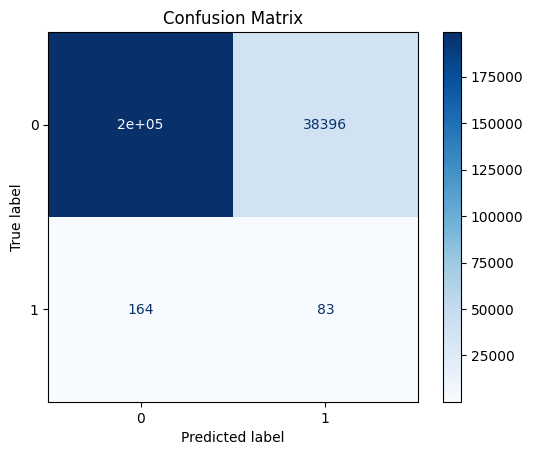

In [21]:
rd = randomforest(X_resampled, y_resampled, X_test, y_test, random_state=68)

Accuracy (Testing Set): 0.9327

Confusion Matrix (Testing Set):
 [[221550  15825]
 [   158     89]]

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      0.93      0.97    237375
           1       0.01      0.36      0.01       247

    accuracy                           0.93    237622
   macro avg       0.50      0.65      0.49    237622
weighted avg       1.00      0.93      0.96    237622



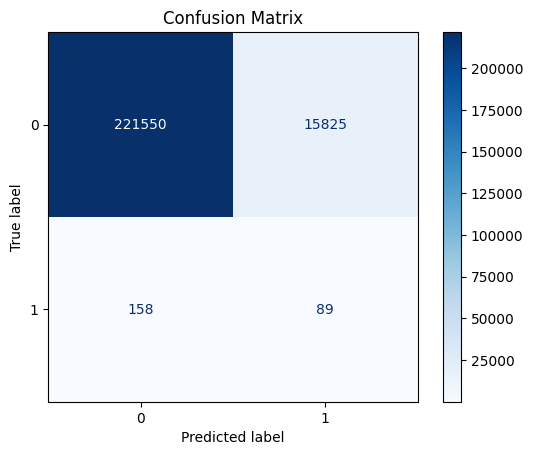

In [22]:
xgb_model = xgboost(X_resampled, y_resampled, X_test, y_test, random_state=68)

0:	learn: 0.6377426	test: 0.6171162	best: 0.6171162 (0)	total: 206ms	remaining: 3m 25s
100:	learn: 0.4101960	test: 0.2684976	best: 0.2684976 (100)	total: 4.41s	remaining: 39.3s
200:	learn: 0.3898346	test: 0.2567858	best: 0.2567858 (200)	total: 8.32s	remaining: 33.1s
300:	learn: 0.3780293	test: 0.2503476	best: 0.2503476 (300)	total: 12.5s	remaining: 29.1s
400:	learn: 0.3713753	test: 0.2470822	best: 0.2470822 (400)	total: 17s	remaining: 25.4s
500:	learn: 0.3666890	test: 0.2448142	best: 0.2448142 (500)	total: 21s	remaining: 21s
600:	learn: 0.3629999	test: 0.2431205	best: 0.2431205 (600)	total: 25.1s	remaining: 16.7s
700:	learn: 0.3601967	test: 0.2418706	best: 0.2418685 (699)	total: 30s	remaining: 12.8s
800:	learn: 0.3580346	test: 0.2409091	best: 0.2409091 (800)	total: 34.5s	remaining: 8.57s
900:	learn: 0.3561155	test: 0.2401454	best: 0.2401454 (900)	total: 38.6s	remaining: 4.24s
999:	learn: 0.3547399	test: 0.2395953	best: 0.2395953 (999)	total: 42.7s	remaining: 0us

bestTest = 0.239595323

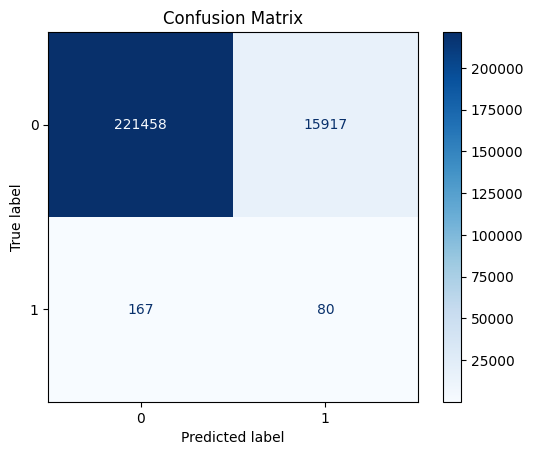

In [23]:
cb = catboost(X_resampled, y_resampled, X_test, y_test, random_state=68)

Accuracy (Testing Set): 0.8385

Confusion Matrix (Testing Set):
 [[199163  38212]
 [   163     84]]

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      0.84      0.91    237375
           1       0.00      0.34      0.00       247

    accuracy                           0.84    237622
   macro avg       0.50      0.59      0.46    237622
weighted avg       1.00      0.84      0.91    237622



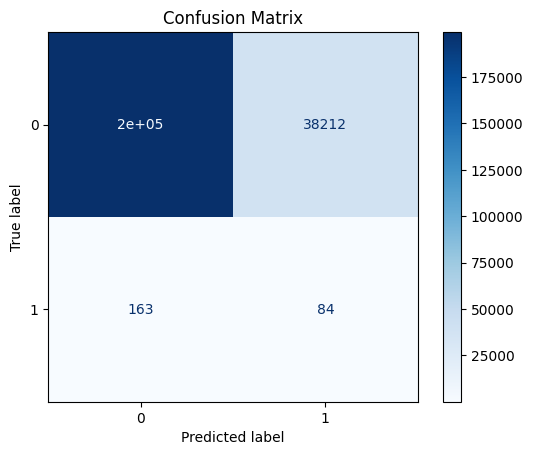

In [24]:
cart = cartmodel(X_resampled, y_resampled, X_test, y_test, random_state=68)

C:\Users\tupha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy (Testing Set): 0.8939

Confusion Matrix (Testing Set):
 [[212309  25066]
 [   136    111]]

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      0.89      0.94    237375
           1       0.00      0.45      0.01       247

    accuracy                           0.89    237622
   macro avg       0.50      0.67      0.48    237622
weighted avg       1.00      0.89      0.94    237622



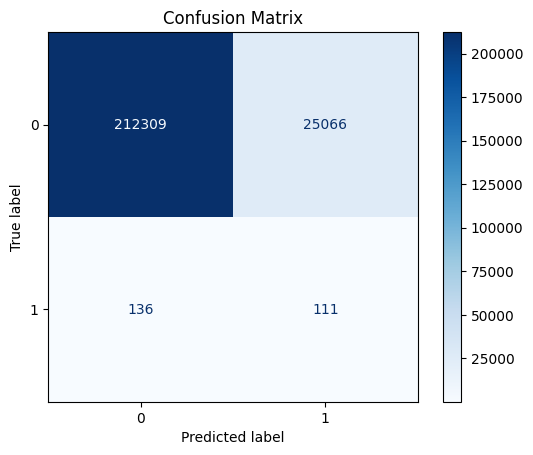

In [25]:
lr = logitregression(X_resampled, y_resampled, X_test, y_test, random_state=68)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=68, stratify=y)
# Handling class imbalance using SMOTE and undersampling
over = SMOTE(sampling_strategy=0.3, random_state=68)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

# Feature scaling
#scaler = StandardScaler()
#X_resampled = scaler.fit_transform(X_resampled)
#X_test = scaler.transform(X_test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=68, stratify=y)
# SMOTE model to create synthetic samples for the minority class (Is_laundering == 1)
# samples of Is_laundering as 1 set at 50% of the samples of Is_landering as 0 
smote = SMOTE(sampling_strategy=0.5, random_state=68)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

Accuracy: 0.9046426677664526

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    237375
           1       0.01      0.50      0.01       247

    accuracy                           0.90    237622
   macro avg       0.50      0.70      0.48    237622
weighted avg       1.00      0.90      0.95    237622



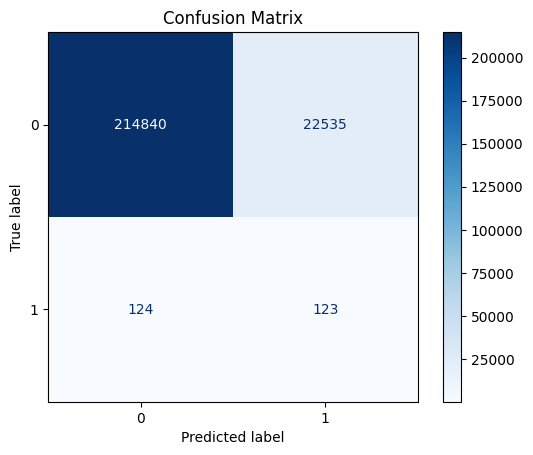

Accuracy: 0.8404230248041006

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    237375
           1       0.00      0.30      0.00       247

    accuracy                           0.84    237622
   macro avg       0.50      0.57      0.46    237622
weighted avg       1.00      0.84      0.91    237622



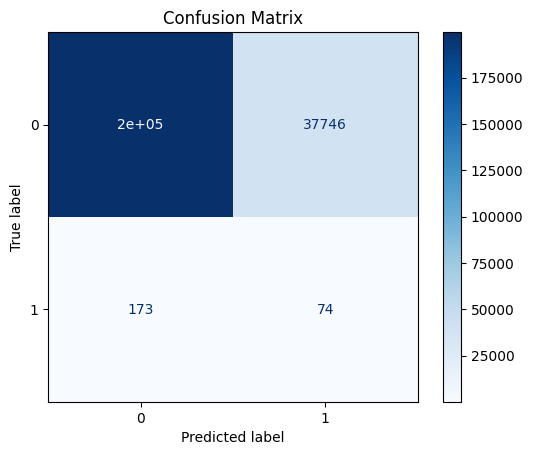

Accuracy (Testing Set): 0.9290

Confusion Matrix (Testing Set):
 [[220653  16722]
 [   159     88]]

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      0.93      0.96    237375
           1       0.01      0.36      0.01       247

    accuracy                           0.93    237622
   macro avg       0.50      0.64      0.49    237622
weighted avg       1.00      0.93      0.96    237622



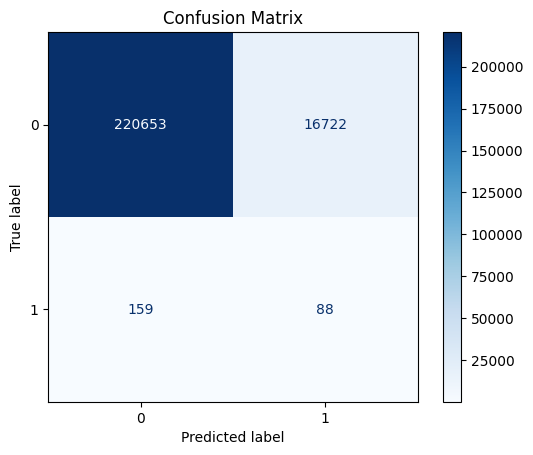

0:	learn: 0.6369649	test: 0.6164164	best: 0.6164164 (0)	total: 92ms	remaining: 1m 31s
100:	learn: 0.4091421	test: 0.2674653	best: 0.2674653 (100)	total: 5.74s	remaining: 51.1s
200:	learn: 0.3890688	test: 0.2554145	best: 0.2554145 (200)	total: 11s	remaining: 43.8s
300:	learn: 0.3778568	test: 0.2496046	best: 0.2496046 (300)	total: 16.8s	remaining: 38.9s
400:	learn: 0.3714252	test: 0.2464550	best: 0.2464550 (400)	total: 23.1s	remaining: 34.5s
500:	learn: 0.3668907	test: 0.2440965	best: 0.2440965 (500)	total: 29.1s	remaining: 29s
600:	learn: 0.3634489	test: 0.2424572	best: 0.2424527 (599)	total: 35.2s	remaining: 23.3s
700:	learn: 0.3606123	test: 0.2411564	best: 0.2411564 (700)	total: 41.1s	remaining: 17.5s
800:	learn: 0.3583754	test: 0.2401767	best: 0.2401767 (800)	total: 47.1s	remaining: 11.7s
900:	learn: 0.3565964	test: 0.2394868	best: 0.2394868 (900)	total: 52.8s	remaining: 5.8s
999:	learn: 0.3551834	test: 0.2388432	best: 0.2388432 (999)	total: 58.5s	remaining: 0us

bestTest = 0.2388432

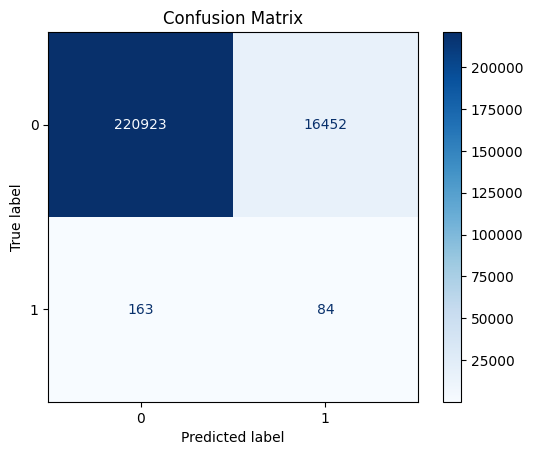

Accuracy (Testing Set): 0.8421

Confusion Matrix (Testing Set):
 [[200034  37341]
 [   175     72]]

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      0.84      0.91    237375
           1       0.00      0.29      0.00       247

    accuracy                           0.84    237622
   macro avg       0.50      0.57      0.46    237622
weighted avg       1.00      0.84      0.91    237622



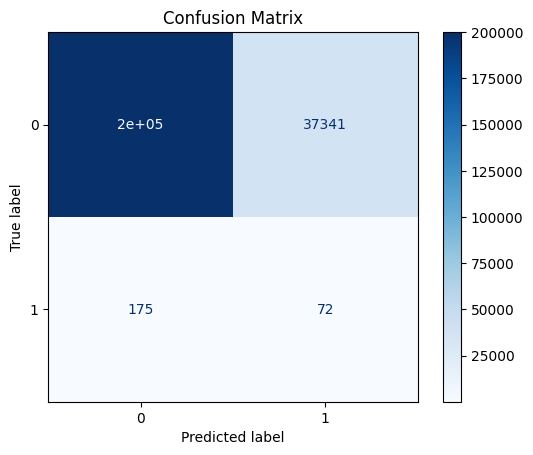

C:\Users\tupha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy (Testing Set): 0.8938

Confusion Matrix (Testing Set):
 [[212273  25102]
 [   136    111]]

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      0.89      0.94    237375
           1       0.00      0.45      0.01       247

    accuracy                           0.89    237622
   macro avg       0.50      0.67      0.48    237622
weighted avg       1.00      0.89      0.94    237622



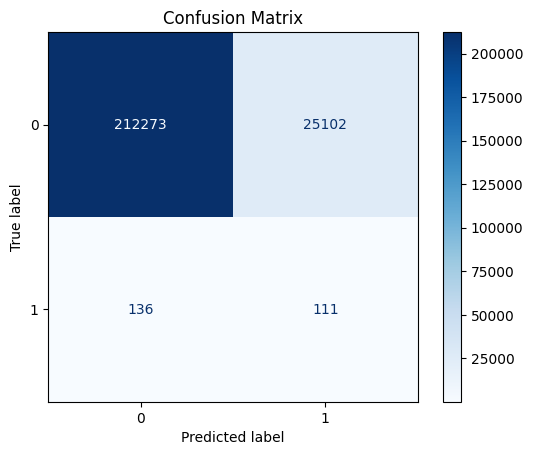

In [27]:
gboost_model = gboost(X_resampled, y_resampled, X_test, y_test, random_state=68)
rd = randomforest(X_resampled, y_resampled, X_test, y_test, random_state=68)
xgb_model = xgboost(X_resampled, y_resampled, X_test, y_test, random_state=68)
cb = catboost(X_resampled, y_resampled, X_test, y_test, random_state=68)
cart = cartmodel(X_resampled, y_resampled, X_test, y_test, random_state=68)
lr = logitregression(X_resampled, y_resampled, X_test, y_test, random_state=68)

Accuracy: 0.902294400350136

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    237375
           1       0.01      0.49      0.01       247

    accuracy                           0.90    237622
   macro avg       0.50      0.70      0.48    237622
weighted avg       1.00      0.90      0.95    237622



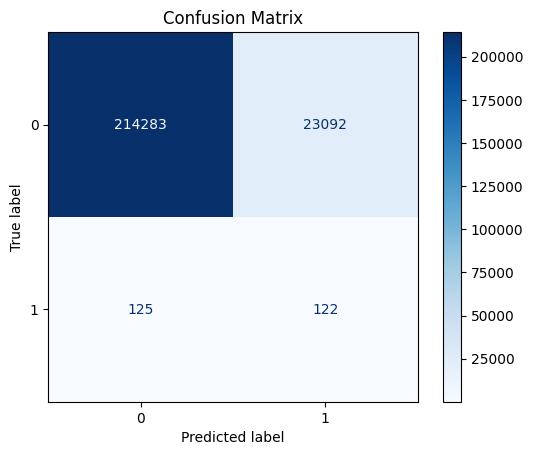

Accuracy: 0.8399264377877469

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    237375
           1       0.00      0.29      0.00       247

    accuracy                           0.84    237622
   macro avg       0.50      0.56      0.46    237622
weighted avg       1.00      0.84      0.91    237622



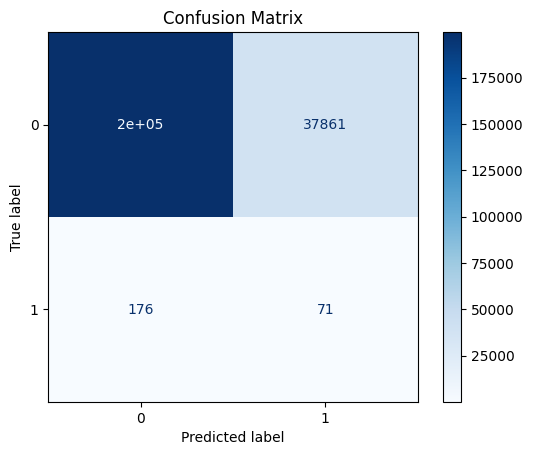

Accuracy (Testing Set): 0.9337

Confusion Matrix (Testing Set):
 [[221791  15584]
 [   162     85]]

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      0.93      0.97    237375
           1       0.01      0.34      0.01       247

    accuracy                           0.93    237622
   macro avg       0.50      0.64      0.49    237622
weighted avg       1.00      0.93      0.96    237622



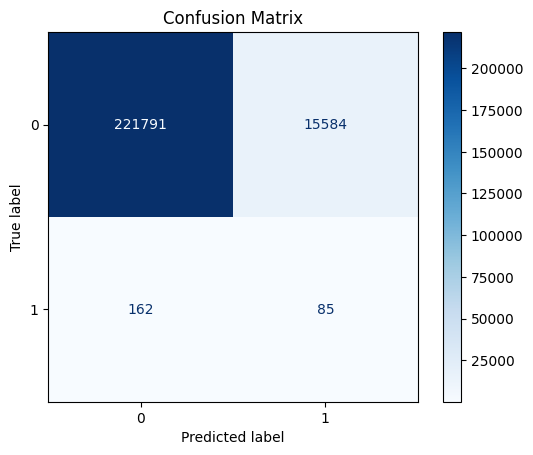

0:	learn: 0.6364111	test: 0.6155272	best: 0.6155272 (0)	total: 78ms	remaining: 1m 17s
100:	learn: 0.4087917	test: 0.2663491	best: 0.2663491 (100)	total: 6.87s	remaining: 1m 1s
200:	learn: 0.3894698	test: 0.2555488	best: 0.2555488 (200)	total: 13.6s	remaining: 54.1s
300:	learn: 0.3782409	test: 0.2493724	best: 0.2493724 (300)	total: 21s	remaining: 48.9s
400:	learn: 0.3716299	test: 0.2459431	best: 0.2459431 (400)	total: 27.9s	remaining: 41.7s
500:	learn: 0.3672389	test: 0.2437323	best: 0.2437323 (500)	total: 35.2s	remaining: 35.1s
600:	learn: 0.3634805	test: 0.2418840	best: 0.2418840 (600)	total: 42s	remaining: 27.9s
700:	learn: 0.3607447	test: 0.2406828	best: 0.2406815 (699)	total: 49.7s	remaining: 21.2s
800:	learn: 0.3586267	test: 0.2396320	best: 0.2396320 (800)	total: 56.6s	remaining: 14.1s
900:	learn: 0.3569716	test: 0.2389049	best: 0.2389049 (900)	total: 1m 3s	remaining: 7s
999:	learn: 0.3556225	test: 0.2383064	best: 0.2383064 (999)	total: 1m 10s	remaining: 0us

bestTest = 0.23830637

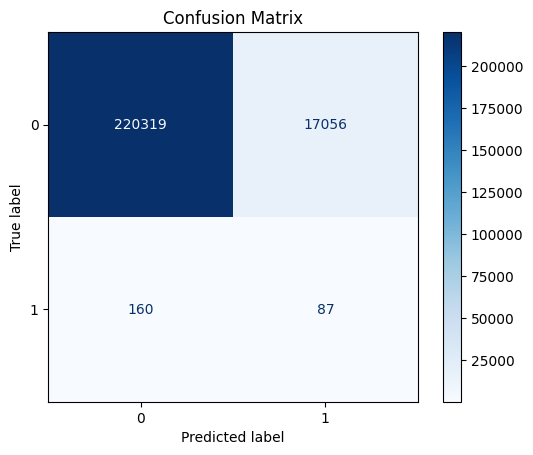

Accuracy (Testing Set): 0.8419

Confusion Matrix (Testing Set):
 [[199978  37397]
 [   177     70]]

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      0.84      0.91    237375
           1       0.00      0.28      0.00       247

    accuracy                           0.84    237622
   macro avg       0.50      0.56      0.46    237622
weighted avg       1.00      0.84      0.91    237622



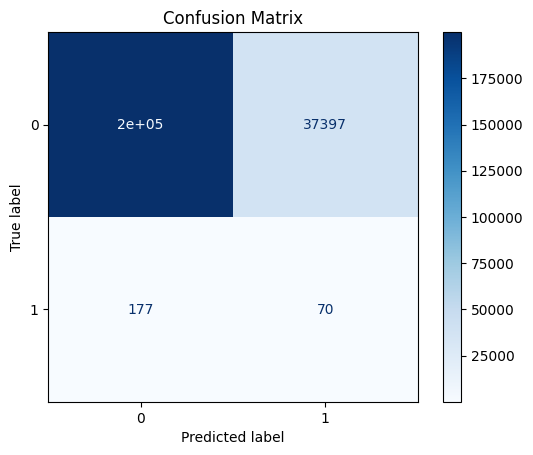

C:\Users\tupha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy (Testing Set): 0.8942

Confusion Matrix (Testing Set):
 [[212372  25003]
 [   137    110]]

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      0.89      0.94    237375
           1       0.00      0.45      0.01       247

    accuracy                           0.89    237622
   macro avg       0.50      0.67      0.48    237622
weighted avg       1.00      0.89      0.94    237622



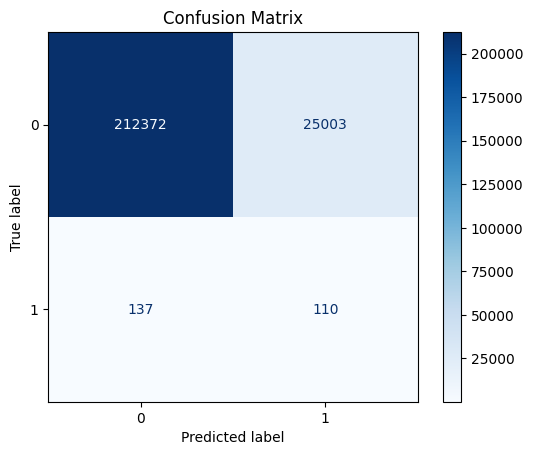

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=68, stratify=y)
# Handling class imbalance using SMOTE and undersampling
over = SMOTE(sampling_strategy=0.4, random_state=68)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

# Feature scaling
#scaler = StandardScaler()
#X_resampled = scaler.fit_transform(X_resampled)
#X_test = scaler.transform(X_test)

gboost_model = gboost(X_resampled, y_resampled, X_test, y_test, random_state=68)
rd = randomforest(X_resampled, y_resampled, X_test, y_test, random_state=68)
xgb_model = xgboost(X_resampled, y_resampled, X_test, y_test, random_state=68)
cb = catboost(X_resampled, y_resampled, X_test, y_test, random_state=68)
cart = cartmodel(X_resampled, y_resampled, X_test, y_test, random_state=68)
lr = logitregression(X_resampled, y_resampled, X_test, y_test, random_state=68)

Accuracy: 0.9050719209500804

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    237375
           1       0.01      0.51      0.01       247

    accuracy                           0.91    237622
   macro avg       0.50      0.71      0.48    237622
weighted avg       1.00      0.91      0.95    237622



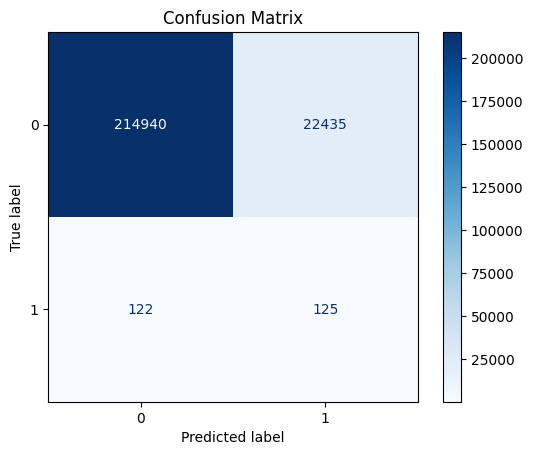

Accuracy: 0.8400148134431997

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91    237375
           1       0.00      0.34      0.00       247

    accuracy                           0.84    237622
   macro avg       0.50      0.59      0.46    237622
weighted avg       1.00      0.84      0.91    237622



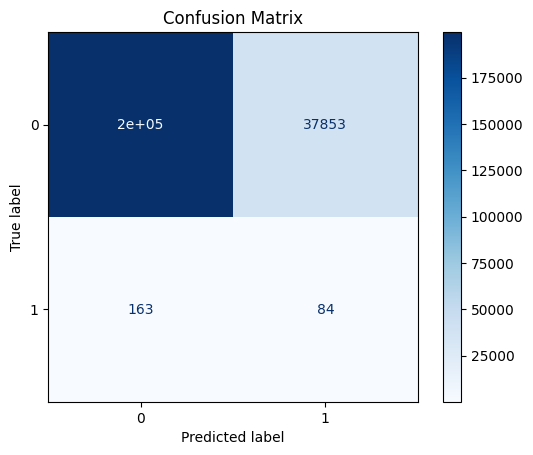

Accuracy (Testing Set): 0.9315

Confusion Matrix (Testing Set):
 [[221263  16112]
 [   159     88]]

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      0.93      0.96    237375
           1       0.01      0.36      0.01       247

    accuracy                           0.93    237622
   macro avg       0.50      0.64      0.49    237622
weighted avg       1.00      0.93      0.96    237622



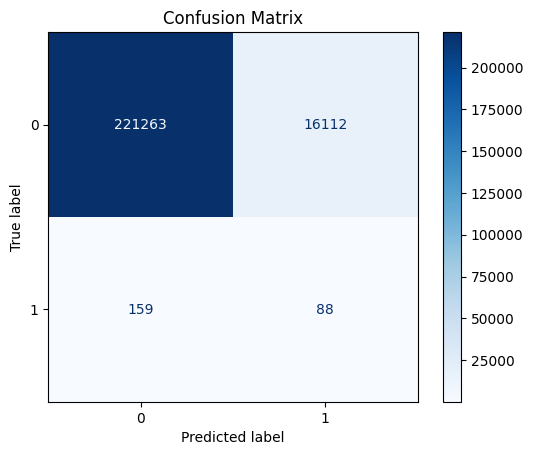

0:	learn: 0.6361962	test: 0.6154298	best: 0.6154298 (0)	total: 96.3ms	remaining: 1m 36s
100:	learn: 0.4077971	test: 0.2664771	best: 0.2664771 (100)	total: 8.5s	remaining: 1m 15s
200:	learn: 0.3884795	test: 0.2550610	best: 0.2550610 (200)	total: 17.8s	remaining: 1m 10s
300:	learn: 0.3777420	test: 0.2495109	best: 0.2495109 (300)	total: 26.6s	remaining: 1m 1s
400:	learn: 0.3709800	test: 0.2459855	best: 0.2459855 (400)	total: 35s	remaining: 52.3s
500:	learn: 0.3666034	test: 0.2437387	best: 0.2437387 (500)	total: 44s	remaining: 43.9s
600:	learn: 0.3628652	test: 0.2418925	best: 0.2418922 (599)	total: 52.1s	remaining: 34.6s
700:	learn: 0.3601641	test: 0.2405854	best: 0.2405854 (700)	total: 1m	remaining: 26s
800:	learn: 0.3582700	test: 0.2397227	best: 0.2397227 (800)	total: 1m 10s	remaining: 17.5s
900:	learn: 0.3564873	test: 0.2388516	best: 0.2388516 (900)	total: 1m 19s	remaining: 8.74s
999:	learn: 0.3550137	test: 0.2382610	best: 0.2382610 (999)	total: 1m 27s	remaining: 0us

bestTest = 0.23826

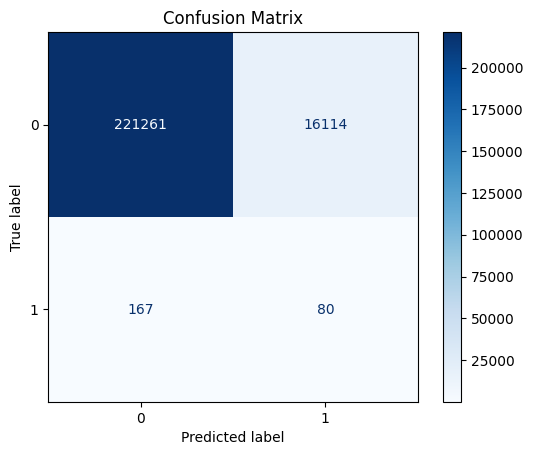

Accuracy (Testing Set): 0.8427

Confusion Matrix (Testing Set):
 [[200170  37205]
 [   165     82]]

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      0.84      0.91    237375
           1       0.00      0.33      0.00       247

    accuracy                           0.84    237622
   macro avg       0.50      0.59      0.46    237622
weighted avg       1.00      0.84      0.91    237622



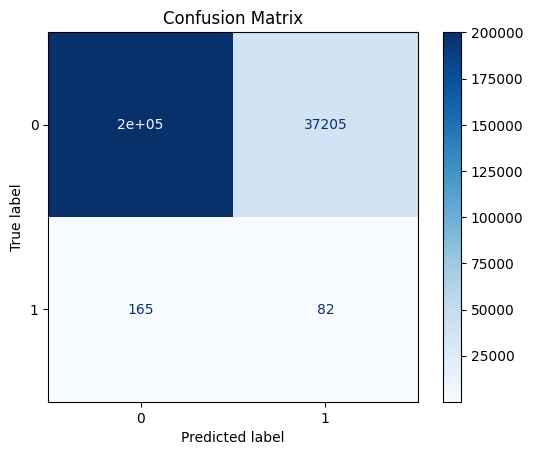

C:\Users\tupha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy (Testing Set): 0.8936

Confusion Matrix (Testing Set):
 [[212237  25138]
 [   135    112]]

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      0.89      0.94    237375
           1       0.00      0.45      0.01       247

    accuracy                           0.89    237622
   macro avg       0.50      0.67      0.48    237622
weighted avg       1.00      0.89      0.94    237622



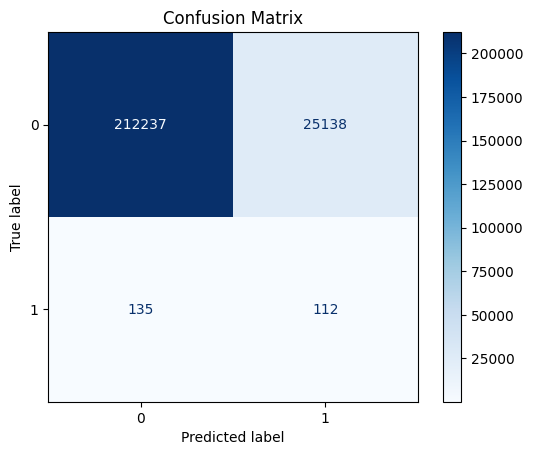

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=68, stratify=y)
# Handling class imbalance using SMOTE and undersampling
over = SMOTE(sampling_strategy=0.5, random_state=68)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

# Feature scaling
#scaler = StandardScaler()
#X_resampled = scaler.fit_transform(X_resampled)
#X_test = scaler.transform(X_test)

gboost_model = gboost(X_resampled, y_resampled, X_test, y_test, random_state=68)
rd = randomforest(X_resampled, y_resampled, X_test, y_test, random_state=68)
xgb_model = xgboost(X_resampled, y_resampled, X_test, y_test, random_state=68)
cb = catboost(X_resampled, y_resampled, X_test, y_test, random_state=68)
cart = cartmodel(X_resampled, y_resampled, X_test, y_test, random_state=68)
lr = logitregression(X_resampled, y_resampled, X_test, y_test, random_state=68)

Accuracy: 0.8656521702535961

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    237375
           1       0.00      0.57      0.01       247

    accuracy                           0.87    237622
   macro avg       0.50      0.72      0.47    237622
weighted avg       1.00      0.87      0.93    237622



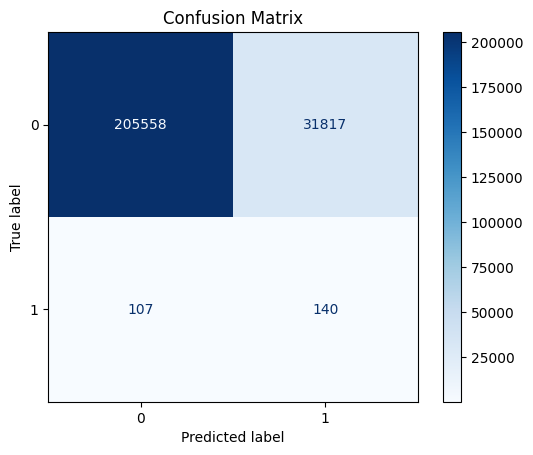

Accuracy: 0.761697149253857

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.76      0.86    237375
           1       0.00      0.40      0.00       247

    accuracy                           0.76    237622
   macro avg       0.50      0.58      0.43    237622
weighted avg       1.00      0.76      0.86    237622



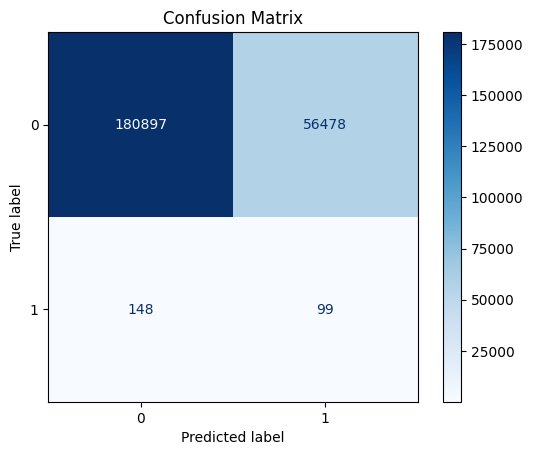

Accuracy (Testing Set): 0.8867

Confusion Matrix (Testing Set):
 [[210596  26779]
 [   144    103]]

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      0.89      0.94    237375
           1       0.00      0.42      0.01       247

    accuracy                           0.89    237622
   macro avg       0.50      0.65      0.47    237622
weighted avg       1.00      0.89      0.94    237622



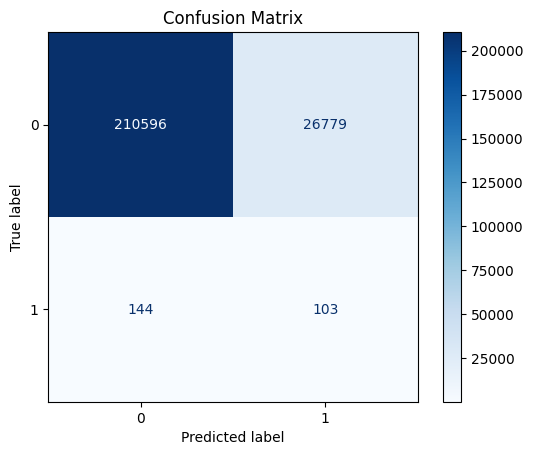

0:	learn: 0.6479816	test: 0.6502606	best: 0.6502606 (0)	total: 68.5ms	remaining: 1m 8s
100:	learn: 0.4425066	test: 0.4357891	best: 0.4357891 (100)	total: 5.7s	remaining: 50.7s
200:	learn: 0.4209527	test: 0.4158014	best: 0.4158014 (200)	total: 11.3s	remaining: 45.1s
300:	learn: 0.4092355	test: 0.4054850	best: 0.4054850 (300)	total: 17.6s	remaining: 40.8s
400:	learn: 0.4012002	test: 0.3988717	best: 0.3988717 (400)	total: 23.9s	remaining: 35.8s
500:	learn: 0.3957559	test: 0.3943149	best: 0.3943149 (500)	total: 30.5s	remaining: 30.3s
600:	learn: 0.3920631	test: 0.3911856	best: 0.3911856 (600)	total: 37.1s	remaining: 24.6s
700:	learn: 0.3893476	test: 0.3890998	best: 0.3890998 (700)	total: 43.1s	remaining: 18.4s
800:	learn: 0.3870000	test: 0.3872038	best: 0.3872038 (800)	total: 49.7s	remaining: 12.3s
900:	learn: 0.3852567	test: 0.3858096	best: 0.3858096 (900)	total: 55.8s	remaining: 6.13s
999:	learn: 0.3838694	test: 0.3847861	best: 0.3847861 (999)	total: 1m 1s	remaining: 0us

bestTest = 0.38

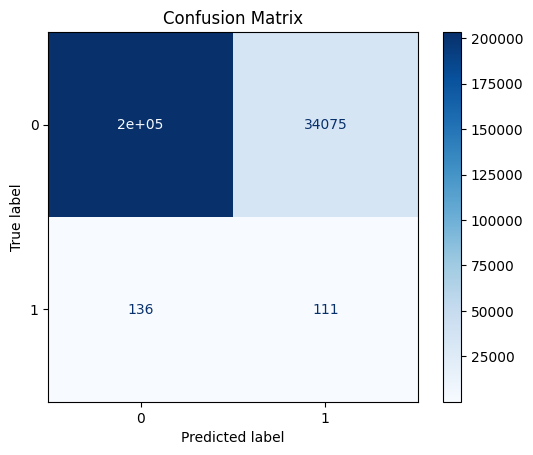

Accuracy (Testing Set): 0.7640

Confusion Matrix (Testing Set):
 [[181446  55929]
 [   151     96]]

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      0.76      0.87    237375
           1       0.00      0.39      0.00       247

    accuracy                           0.76    237622
   macro avg       0.50      0.58      0.43    237622
weighted avg       1.00      0.76      0.87    237622



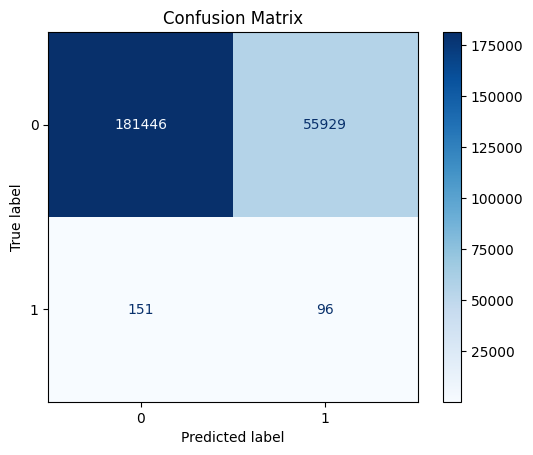

C:\Users\tupha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy (Testing Set): 0.8837

Confusion Matrix (Testing Set):
 [[209867  27508]
 [   127    120]]

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      0.88      0.94    237375
           1       0.00      0.49      0.01       247

    accuracy                           0.88    237622
   macro avg       0.50      0.68      0.47    237622
weighted avg       1.00      0.88      0.94    237622



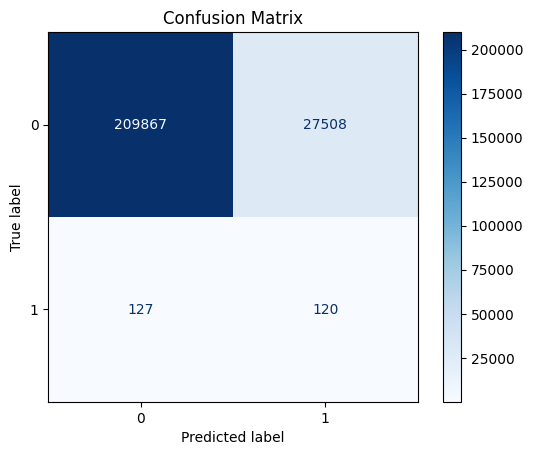

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=68, stratify=y)
# Handling class imbalance using SMOTE and undersampling
over = SMOTE(sampling_strategy=0.5, random_state=68)
under = RandomUnderSampler(sampling_strategy=1.0)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

# Feature scaling
#scaler = StandardScaler()
#X_resampled = scaler.fit_transform(X_resampled)
#X_test = scaler.transform(X_test)

gboost_model = gboost(X_resampled, y_resampled, X_test, y_test, random_state=68)
rd = randomforest(X_resampled, y_resampled, X_test, y_test, random_state=68)
xgb_model = xgboost(X_resampled, y_resampled, X_test, y_test, random_state=68)
cb = catboost(X_resampled, y_resampled, X_test, y_test, random_state=68)
cart = cartmodel(X_resampled, y_resampled, X_test, y_test, random_state=68)
lr = logitregression(X_resampled, y_resampled, X_test, y_test, random_state=68)

Accuracy: 0.8671377229381118

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    237375
           1       0.00      0.57      0.01       247

    accuracy                           0.87    237622
   macro avg       0.50      0.72      0.47    237622
weighted avg       1.00      0.87      0.93    237622



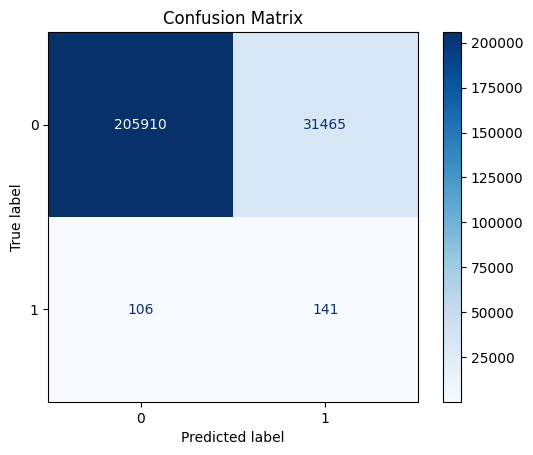

Accuracy: 0.7516223245322403

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86    237375
           1       0.00      0.43      0.00       247

    accuracy                           0.75    237622
   macro avg       0.50      0.59      0.43    237622
weighted avg       1.00      0.75      0.86    237622



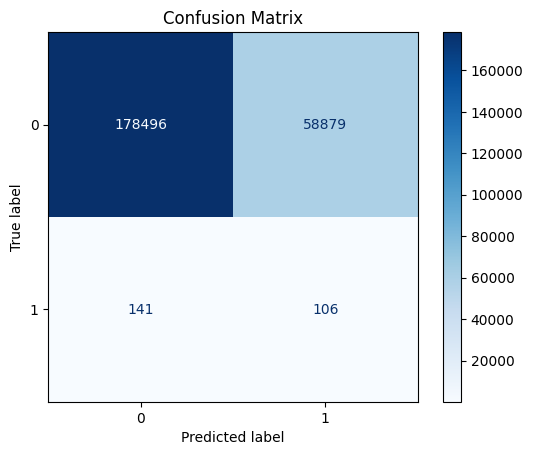

Accuracy (Testing Set): 0.8604

Confusion Matrix (Testing Set):
 [[204334  33041]
 [   135    112]]

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      0.86      0.92    237375
           1       0.00      0.45      0.01       247

    accuracy                           0.86    237622
   macro avg       0.50      0.66      0.47    237622
weighted avg       1.00      0.86      0.92    237622



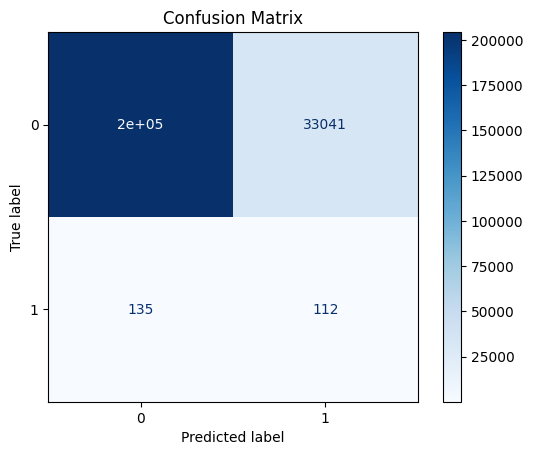

0:	learn: 0.6508888	test: 0.6467453	best: 0.6467453 (0)	total: 72.9ms	remaining: 1m 12s
100:	learn: 0.4563062	test: 0.4535934	best: 0.4535934 (100)	total: 6.56s	remaining: 58.4s
200:	learn: 0.4337243	test: 0.4326500	best: 0.4326500 (200)	total: 13.8s	remaining: 54.9s
300:	learn: 0.4211397	test: 0.4219873	best: 0.4219873 (300)	total: 21.2s	remaining: 49.1s
400:	learn: 0.4138426	test: 0.4155382	best: 0.4155382 (400)	total: 27.9s	remaining: 41.6s
500:	learn: 0.4087314	test: 0.4114017	best: 0.4114017 (500)	total: 34.2s	remaining: 34s
600:	learn: 0.4051097	test: 0.4083834	best: 0.4083834 (600)	total: 40.9s	remaining: 27.2s
700:	learn: 0.4021845	test: 0.4060443	best: 0.4060443 (700)	total: 47.5s	remaining: 20.3s
800:	learn: 0.3997713	test: 0.4041732	best: 0.4041732 (800)	total: 54.6s	remaining: 13.6s
900:	learn: 0.3980405	test: 0.4028547	best: 0.4028536 (898)	total: 1m 3s	remaining: 6.94s
999:	learn: 0.3966151	test: 0.4017219	best: 0.4017219 (999)	total: 1m 10s	remaining: 0us

bestTest = 0.4

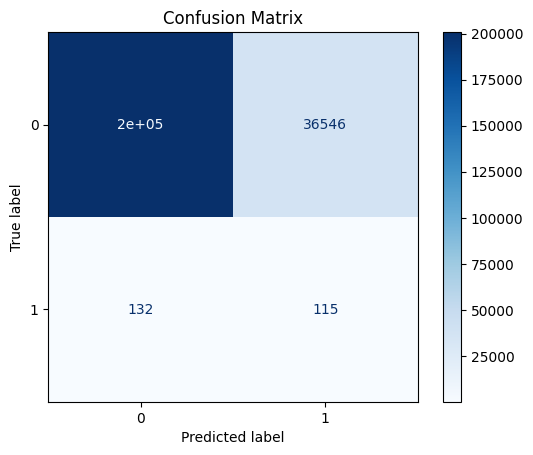

Accuracy (Testing Set): 0.7540

Confusion Matrix (Testing Set):
 [[179072  58303]
 [   144    103]]

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      0.75      0.86    237375
           1       0.00      0.42      0.00       247

    accuracy                           0.75    237622
   macro avg       0.50      0.59      0.43    237622
weighted avg       1.00      0.75      0.86    237622



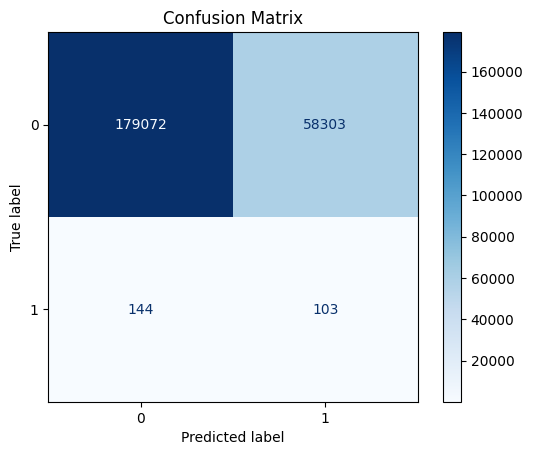

C:\Users\tupha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy (Testing Set): 0.8807

Confusion Matrix (Testing Set):
 [[209144  28231]
 [   127    120]]

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      0.88      0.94    237375
           1       0.00      0.49      0.01       247

    accuracy                           0.88    237622
   macro avg       0.50      0.68      0.47    237622
weighted avg       1.00      0.88      0.94    237622



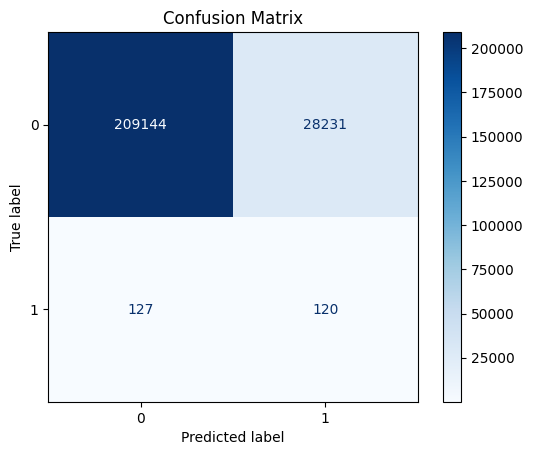

In [45]:
# ADASYN
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=68, stratify=y)
# Handling class imbalance using ADASYN and undersampling
over = ADASYN(sampling_strategy=0.5, random_state=68)
under = RandomUnderSampler(sampling_strategy=1.0)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

# Feature scaling
#scaler = StandardScaler()
#X_resampled = scaler.fit_transform(X_resampled)
#X_test = scaler.transform(X_test)

gboost_model = gboost(X_resampled, y_resampled, X_test, y_test, random_state=68)
rd = randomforest(X_resampled, y_resampled, X_test, y_test, random_state=68)
xgb_model = xgboost(X_resampled, y_resampled, X_test, y_test, random_state=68)
cb = catboost(X_resampled, y_resampled, X_test, y_test, random_state=68)
cart = cartmodel(X_resampled, y_resampled, X_test, y_test, random_state=68)
lr = logitregression(X_resampled, y_resampled, X_test, y_test, random_state=68)

Accuracy: 0.8680930216899109

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93    237375
           1       0.00      0.55      0.01       247

    accuracy                           0.87    237622
   macro avg       0.50      0.71      0.47    237622
weighted avg       1.00      0.87      0.93    237622



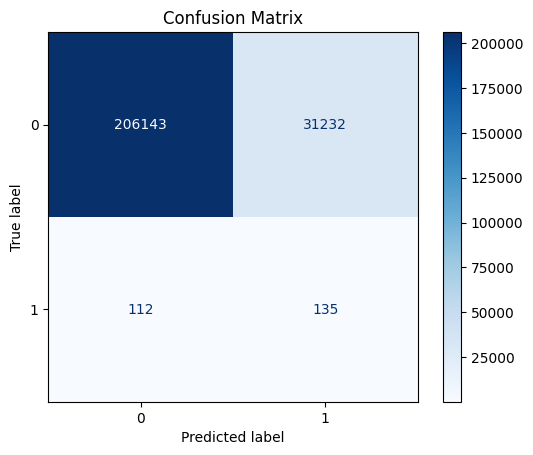

Accuracy: 0.7331602292717004

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.73      0.85    237375
           1       0.00      0.45      0.00       247

    accuracy                           0.73    237622
   macro avg       0.50      0.59      0.42    237622
weighted avg       1.00      0.73      0.85    237622



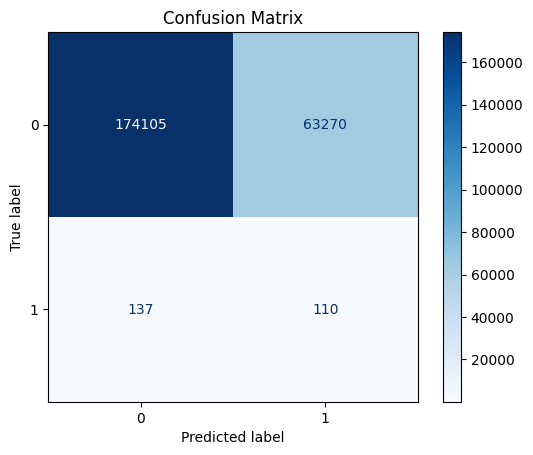

Accuracy (Testing Set): 0.8416

Confusion Matrix (Testing Set):
 [[199851  37524]
 [   125    122]]

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      0.84      0.91    237375
           1       0.00      0.49      0.01       247

    accuracy                           0.84    237622
   macro avg       0.50      0.67      0.46    237622
weighted avg       1.00      0.84      0.91    237622



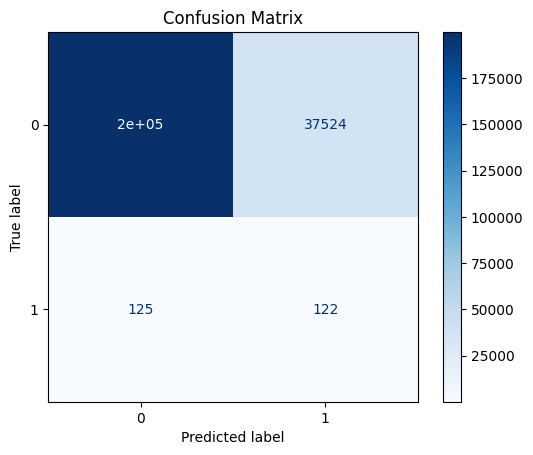

0:	learn: 0.6485429	test: 0.6484258	best: 0.6484258 (0)	total: 101ms	remaining: 1m 40s
100:	learn: 0.4627596	test: 0.4614144	best: 0.4614144 (100)	total: 5.84s	remaining: 52s
200:	learn: 0.4459509	test: 0.4471229	best: 0.4471229 (200)	total: 11.5s	remaining: 45.6s
300:	learn: 0.4372290	test: 0.4394485	best: 0.4394485 (300)	total: 17.7s	remaining: 41s
400:	learn: 0.4318538	test: 0.4349973	best: 0.4349973 (400)	total: 24.2s	remaining: 36.1s
500:	learn: 0.4278773	test: 0.4316626	best: 0.4316626 (500)	total: 30.3s	remaining: 30.1s
600:	learn: 0.4252011	test: 0.4293198	best: 0.4293198 (600)	total: 36.4s	remaining: 24.2s
700:	learn: 0.4228230	test: 0.4273438	best: 0.4273438 (700)	total: 42.5s	remaining: 18.1s
800:	learn: 0.4209432	test: 0.4258706	best: 0.4258706 (800)	total: 48.7s	remaining: 12.1s
900:	learn: 0.4194560	test: 0.4246079	best: 0.4246079 (900)	total: 54.8s	remaining: 6.02s
999:	learn: 0.4184074	test: 0.4238062	best: 0.4238062 (999)	total: 1m	remaining: 0us

bestTest = 0.42380615

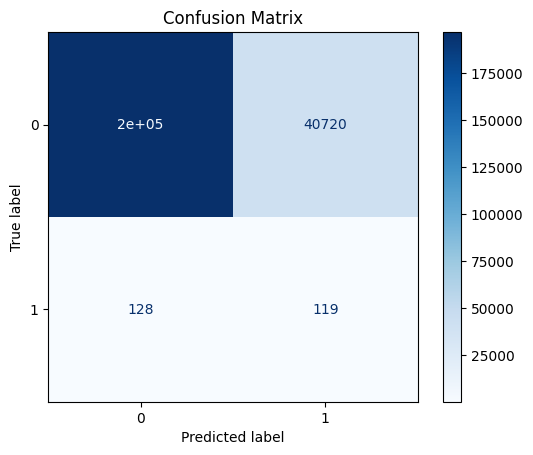

Accuracy (Testing Set): 0.7359

Confusion Matrix (Testing Set):
 [[174765  62610]
 [   138    109]]

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      0.74      0.85    237375
           1       0.00      0.44      0.00       247

    accuracy                           0.74    237622
   macro avg       0.50      0.59      0.43    237622
weighted avg       1.00      0.74      0.85    237622



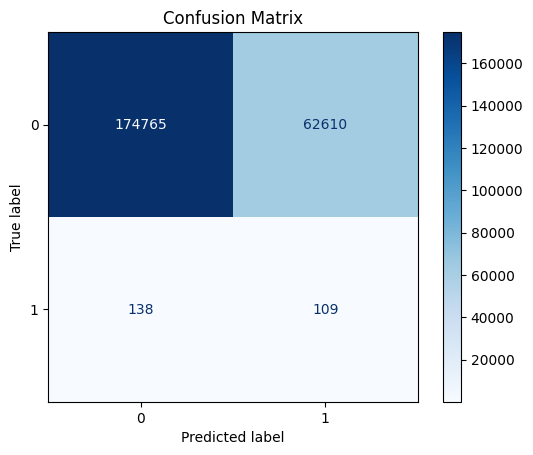

C:\Users\tupha\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy (Testing Set): 0.8740

Confusion Matrix (Testing Set):
 [[207565  29810]
 [   128    119]]

Classification Report (Testing Set):
               precision    recall  f1-score   support

           0       1.00      0.87      0.93    237375
           1       0.00      0.48      0.01       247

    accuracy                           0.87    237622
   macro avg       0.50      0.68      0.47    237622
weighted avg       1.00      0.87      0.93    237622



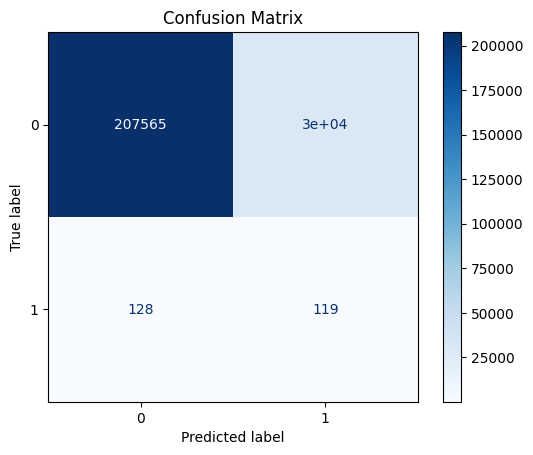

In [122]:
# SMOTENC
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=68, stratify=y)

X_train_copy = X_train.copy()
X_train_copy[X_train.columns[1:].to_list()] = X_train_copy[X_train.columns[1:].to_list()].astype('int64')
X_train_copy[X_train.columns[1:].to_list()] = X_train_copy[X_train.columns[1:].to_list()].astype(pd.CategoricalDtype(categories=[0, 1]))

# Handling class imbalance using SMOTENC and undersampling
over = SMOTENC(categorical_features='auto', sampling_strategy=0.5, random_state=68)
under = RandomUnderSampler(sampling_strategy=1.0)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_resampled, y_resampled = pipeline.fit_resample(X_train_copy, y_train)
X_resampled[X_resampled.columns[1:].to_list()] = X_resampled[X_resampled.columns[1:].to_list()].astype('int32')

# Feature scaling
#scaler = StandardScaler()
#X_resampled = scaler.fit_transform(X_resampled)
#X_test = scaler.transform(X_test)

gboost_model = gboost(X_resampled, y_resampled, X_test, y_test, random_state=68)
rd = randomforest(X_resampled, y_resampled, X_test, y_test, random_state=68)
xgb_model = xgboost(X_resampled, y_resampled, X_test, y_test, random_state=68)
cb = catboost(X_resampled, y_resampled, X_test, y_test, random_state=68)
cart = cartmodel(X_resampled, y_resampled, X_test, y_test, random_state=68)
lr = logitregression(X_resampled, y_resampled, X_test, y_test, random_state=68)

In [121]:
X_resampled['Payment_currency_Euro'].value_counts()

Payment_currency_Euro
0.0    52826
1.0      551
Name: count, dtype: int64

In [ ]:
lr = logitregression(X_resampled, y_resampled, X_test, y_test, random_state=68, max_iter=125)

In [ ]:
lr = logitregression(X_resampled, y_resampled, X_test, y_test, random_state=68, max_iter=75)

In [ ]:
lr = logitregression(X_resampled, y_resampled, X_test, y_test, random_state=68, max_iter=50)

In [ ]:
X_resampled['Payment_type_Cross-border'].astype(int)

In [115]:
X_resampled.head()

,Amount,Payment_currency_Dirham,Payment_currency_Euro,Payment_currency_Indian rupee,Payment_currency_Mexican Peso,Payment_currency_Moroccan dirham,Payment_currency_Naira,Payment_currency_Pakistani rupee,Payment_currency_Swiss franc,Payment_currency_Turkish lira,...,Receiver_bank_location_Turkey,Receiver_bank_location_UAE,Receiver_bank_location_UK,Receiver_bank_location_USA,Payment_type_Cash Deposit,Payment_type_Cash Withdrawal,Payment_type_Cheque,Payment_type_Credit card,Payment_type_Cross-border,Payment_type_Debit card
21781,-0.166268,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
22166,-0.118957,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
190960,0.133350,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
81480,0.621365,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
352294,-0.266291,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [ ]:
pd.DataFrame(X_resampled)

In [ ]:
pd.DataFrame(X_test).head()

In [ ]:
y_resampled.shape

In [ ]:
y_test.shape

In [32]:
X_train.shape

(712863, 65)

In [35]:
y_train.value_counts()

Is_laundering
0    712123
1       740
Name: count, dtype: int64

In [114]:
X_resampled.shape

(712122, 65)

In [41]:
y_resampled.value_counts(normalize=True)

Is_laundering
0    0.5
1    0.5
Name: proportion, dtype: float64

In [42]:
y_resampled.value_counts()

Is_laundering
0    356061
1    356061
Name: count, dtype: int64

In [37]:
y_test.value_counts()

Is_laundering
0    237375
1       247
Name: count, dtype: int64

In [ ]:
y_pred = cart.predict(X_test)

In [ ]:
pd.Series(y_pred).value_counts()

In [ ]:
df['Sender_account'].nunique()

In [ ]:
df['Receiver_account'].nunique()

In [ ]:
df.info()

In [ ]:
df.columns

In [ ]:
# Plot the count of transactions by top 20 transaction descriptions
plt.figure(figsize=(12, 8))
ax = sns.countplot(y='TRANSACTION_DESCRIPTION', data=df, order=df['TRANSACTION_DESCRIPTION'].value_counts().nlargest(20).index)
plt.title('Count of Transactions by Description')
plt.xlabel('Count')
plt.ylabel('Transaction Description')
for container in ax.containers:
    ax.bar_label(container, label_type='edge')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
plt.show()